## Топовые предикторы

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
import numpy as np
from sklearn.metrics import r2_score
from tqdm.auto import tqdm
from src.core import predict_and_average, fill_na_from_lookup, remove_young_data, upscale_with_nans

pd.set_option('display.max_rows', 50)

In [2]:
df = pd.read_csv('train_data.csv', index_col=0)

print(df.shape)
# Remove rows with age below 5 and above 85
df = df[(df['age']>15) & (df['age']<85)]

age_bins = np.arange(15, 90, 5)
age_labels = [f'{age_bins[i]}-{age_bins[i+1]-1}' for i in range(len(age_bins)-1)]
# Create a new column for age groups
df['Age Group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=False)

print(df.shape)

# Формируем отложенную выборку
df = df.sample(frac=1, random_state=42)
test_df = df[int(df.shape[0]*0.8):]
df = df[:int(df.shape[0]*0.8)]
print('test_df.shape, df.shape', test_df.shape, df.shape)

df[:5]

(121745, 19)
(78051, 20)
test_df.shape, df.shape (15611, 20) (62440, 20)


,Waist Circumference (cm),Standing Height (cm),Weight (kg),Systolic blood pressure average,Estimated Glomerular Filtration Rate (mL/min/1.73 m2),alpha-tocopherol (µg/dL),Serum homocysteine: SI (umol/L),Serum ferritin (ng/mL),Serum creatinine (mg/dL),Serum blood urea nitrogen (mg/dL),Serum HDL cholesterol (mg/dL),Serum albumin: SI (g/L),Serum C-reactive protein (mg/dL),Body Mass Index (kg/m**2),Waist to Height ratio,gender,age,SEQN,SEQN_new,Age Group
118445,109.7,168.0,86.3,NaN,117.006838,825.0,NaN,88.8,0.82,13.0,49.0,39.0,NaN,30.58,0.652976,1,32,99297.0,C-99297,30-34
80656,88.8,177.8,70.8,NaN,59.731341,NaN,NaN,NaN,1.27,10.0,34.0,38.0,0.40,22.40,0.499438,1,63,56583.0,C-56583,60-64
81934,106.8,175.7,92.2,NaN,116.620323,NaN,NaN,16.0,0.74,9.0,37.0,42.0,0.54,29.87,0.607854,2,20,57965.0,C-57965,20-24
81243,130.0,175.4,119.6,NaN,107.327123,NaN,NaN,NaN,1.01,9.0,25.0,42.0,0.39,38.88,0.741163,1,19,57220.0,C-57220,15-19
109034,76.5,180.3,72.0,NaN,64.844737,NaN,NaN,NaN,1.14,13.0,37.0,45.0,NaN,22.15,0.424293,1,17,88998.0,C-88998,15-19


In [3]:
features = [
# 'Waist Circumference (cm)', эти фичи не участвуют в создании модели
#  'Standing Height (cm)',
#  'Weight (kg)',
 'Systolic blood pressure average',
 'Estimated Glomerular Filtration Rate (mL/min/1.73 m2)',
 'alpha-tocopherol (µg/dL)',
 'Serum homocysteine: SI (umol/L)',
 'Serum ferritin (ng/mL)',
 'Serum creatinine (mg/dL)',
 'Serum blood urea nitrogen (mg/dL)',
 'Serum HDL cholesterol (mg/dL)',
 'Serum albumin:  SI (g/L)',
 'Serum C-reactive protein (mg/dL)',
 'Body Mass Index (kg/m**2)',
 'Waist to Height ratio']

meta_features = ['gender', 'age', 'SEQN', 'SEQN_new']


In [4]:
print(df[features].describe())
print(df[features].isnull().sum())


       Systolic blood pressure average  \
count                      8700.000000   
mean                        122.833678   
std                          20.014779   
min                          72.000000   
25%                         109.000000   
50%                         119.000000   
75%                         132.000000   
max                         266.000000   

       Estimated Glomerular Filtration Rate (mL/min/1.73 m2)  \
count                                       58216.000000       
mean                                           89.814329       
std                                            24.691208       
min                                             1.854450       
25%                                            72.931985       
50%                                            90.005900       
75%                                           107.470172       
max                                           300.155982       

       alpha-tocopherol (µg/dL)  Serum homoc

In [5]:
df[features+['age']].corr()

,Systolic blood pressure average,Estimated Glomerular Filtration Rate (mL/min/1.73 m2),alpha-tocopherol (µg/dL),Serum homocysteine: SI (umol/L),Serum ferritin (ng/mL),Serum creatinine (mg/dL),Serum blood urea nitrogen (mg/dL),Serum HDL cholesterol (mg/dL),Serum albumin: SI (g/L),Serum C-reactive protein (mg/dL),Body Mass Index (kg/m**2),Waist to Height ratio,age
Systolic blood pressure average,1.000000,-0.397408,0.263734,0.258408,0.186468,0.146641,0.271840,-0.005828,-0.055313,0.078372,0.200649,0.289510,0.566147
Estimated Glomerular Filtration Rate (mL/min/1.73 m2),-0.397408,1.000000,-0.229404,-0.394672,-0.220216,-0.596487,-0.525272,0.009762,0.149728,-0.057746,-0.042383,-0.115021,-0.612752
alpha-tocopherol (µg/dL),0.263734,-0.229404,1.000000,0.056737,0.118812,0.037022,0.179701,0.053416,-0.073896,0.033562,0.051716,0.170605,0.436348
Serum homocysteine: SI (umol/L),0.258408,-0.394672,0.056737,1.000000,0.206607,0.349014,0.295060,-0.052258,0.034161,0.025656,0.010284,0.053742,0.323162
Serum ferritin (ng/mL),0.186468,-0.220216,0.118812,0.206607,1.000000,0.257838,0.231938,-0.115186,0.049513,0.098066,0.059783,0.096820,0.288434
Serum creatinine (mg/dL),0.146641,-0.596487,0.037022,0.349014,0.257838,1.000000,0.522279,-0.096109,-0.039306,0.038578,0.003324,-0.005280,0.197755
Serum blood urea nitrogen (mg/dL),0.271840,-0.525272,0.179701,0.295060,0.231938,0.522279,1.000000,-0.061680,-0.017165,0.031317,0.046168,0.115291,0.423054
Serum HDL cholesterol (mg/dL),-0.005828,0.009762,0.053416,-0.052258,-0.115186,-0.096109,-0.061680,1.000000,-0.040642,-0.047746,-0.239166,-0.221838,0.049847
Serum albumin: SI (g/L),-0.055313,0.149728,-0.073896,0.034161,0.049513,-0.039306,-0.017165,-0.040642,1.000000,-0.289478,-0.273020,-0.334454,-0.217383
Serum C-reactive protein (mg/dL),0.078372,-0.057746,0.033562,0.025656,0.098066,0.038578,0.031317,-0.047746,-0.289478,1.000000,0.210460,0.232599,0.108787


# Undersampling

In [6]:
df_reduced = remove_young_data(df, age_column='age', age_threshold=20, removal_fraction=0.4)
# Now `df_reduced` will have 20% fewer rows for individuals below 20 years of age.
df_reduced.shape

(59306, 20)

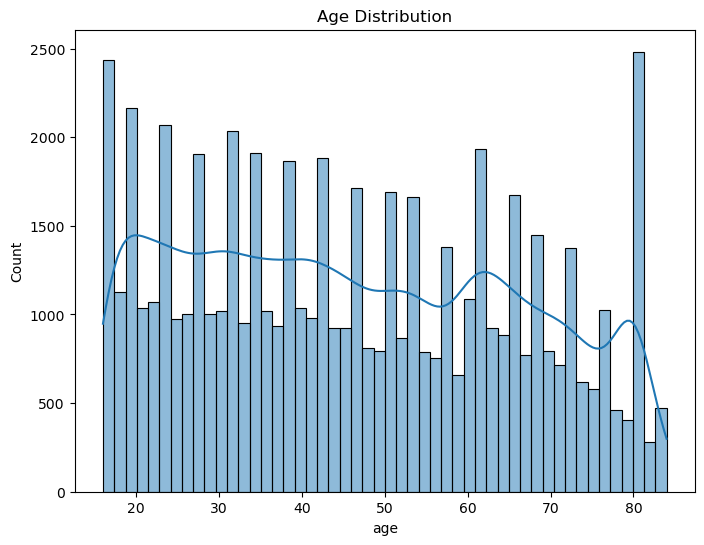

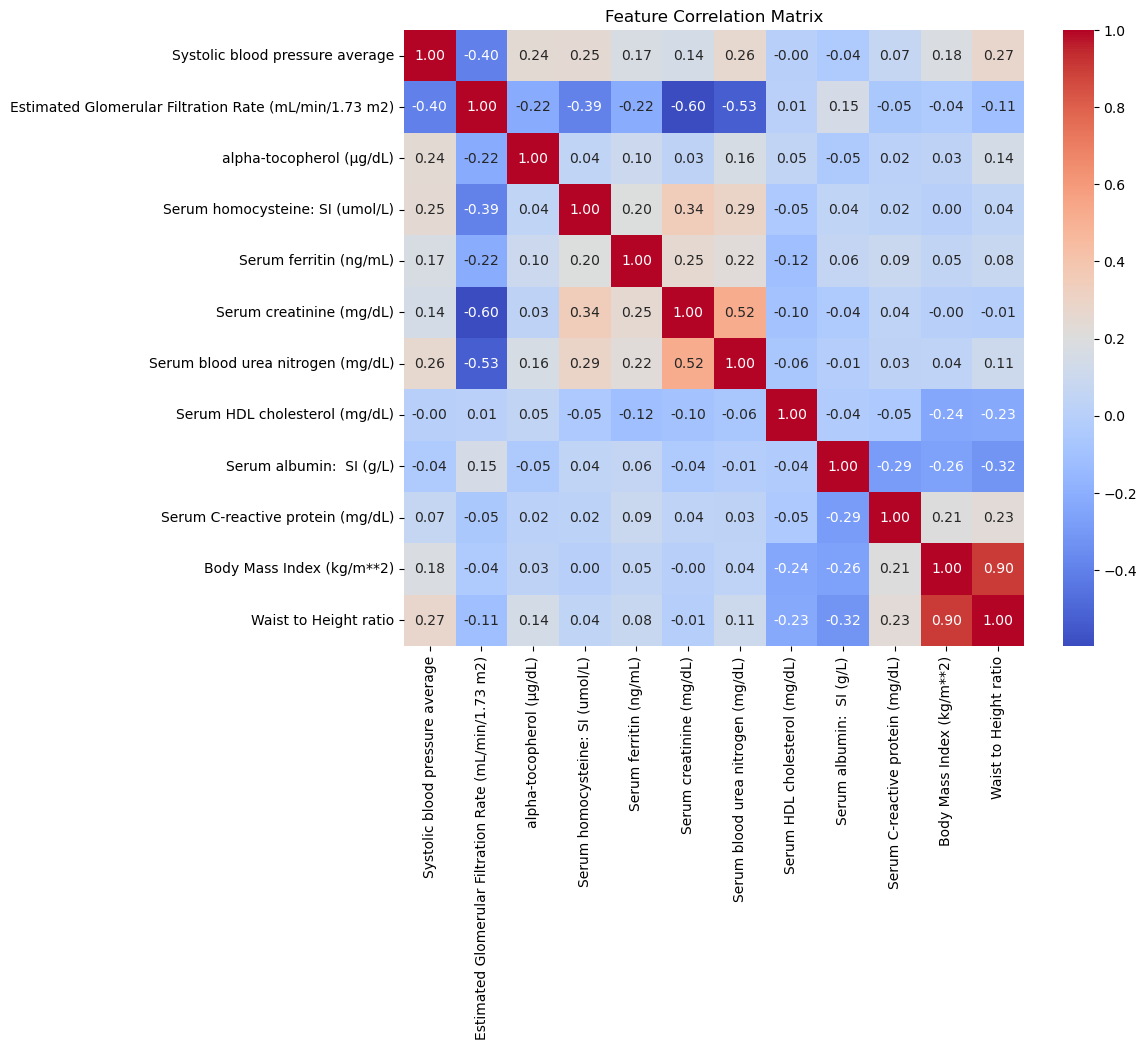

In [7]:
# Distribution of the target variable
plt.figure(figsize=(8, 6))
sns.histplot(df_reduced['age'], bins=50, kde=True, )
plt.title('Age Distribution')
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_reduced[features].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()


# Upscaling

<Axes: xlabel='age', ylabel='Count'>

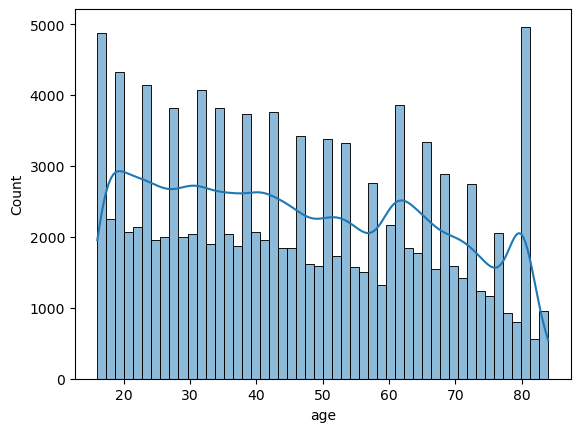

In [8]:

# Example usage:
# This example doubles the dataset size with augmented data having at least 40% missing values in each feature
df_upscaled = upscale_with_nans(df_reduced, features, missing_fraction=0.4, upscale_factor=1)
sns.histplot(df_upscaled['age'], bins=50, kde=True, )

In [9]:
df_reduced[features].isna().sum() / df_reduced.shape[0]

Systolic blood pressure average                          0.865208
Estimated Glomerular Filtration Rate (mL/min/1.73 m2)    0.066418
alpha-tocopherol (µg/dL)                                 0.665363
Serum homocysteine: SI (umol/L)                          0.639986
Serum ferritin (ng/mL)                                   0.467558
Serum creatinine (mg/dL)                                 0.066182
Serum blood urea nitrogen (mg/dL)                        0.066233
Serum HDL cholesterol (mg/dL)                            0.063417
Serum albumin:  SI (g/L)                                 0.066132
Serum C-reactive protein (mg/dL)                         0.354450
Body Mass Index (kg/m**2)                                0.015007
Waist to Height ratio                                    0.058662
dtype: float64

In [10]:
df_upscaled[features].isna().sum() / df_upscaled.shape[0]

Systolic blood pressure average                          0.892178
Estimated Glomerular Filtration Rate (mL/min/1.73 m2)    0.253018
alpha-tocopherol (µg/dL)                                 0.732093
Serum homocysteine: SI (umol/L)                          0.712095
Serum ferritin (ng/mL)                                   0.572961
Serum creatinine (mg/dL)                                 0.253313
Serum blood urea nitrogen (mg/dL)                        0.253195
Serum HDL cholesterol (mg/dL)                            0.251054
Serum albumin:  SI (g/L)                                 0.252647
Serum C-reactive protein (mg/dL)                         0.483408
Body Mass Index (kg/m**2)                                0.212137
Waist to Height ratio                                    0.246518
dtype: float64

In [11]:
def fill_na_with_age_group_mean(df, features=None, age_bins=None):
    """
    Fills NaN values in specified columns with the mean of their respective age group.

    Parameters:
    - df: pandas.DataFrame, the original dataset.
    - features: list of str, the names of the columns for which NaN values should be filled with the group mean.
    - age_bins: list of int, the bin edges for grouping ages. If None, default age groups are used.

    Returns:
    - df_filled: pandas.DataFrame, the dataset after filling NaN values with age group means.
    """
    # Create a copy of the DataFrame to avoid modifying the original data
    df_filled = df.copy()
    
    # Fill NaN for each specified target column
    for col in features:
        if col in df_filled.columns:
            # Calculate and fill NaNs with the mean of their age group
            df_filled[col] = df_filled.groupby('Age Group')[col].transform(lambda x: x.fillna(x.mean()))
    
    return df_filled

# Example usage:
df_filled = fill_na_with_age_group_mean(df_upscaled, 
            features=features)

df_filled[features].isna().sum() / df_filled.shape[0]

/var/folders/gm/xnklr9cn25d9zttg6821cbrw0000gp/T/ipykernel_86453/644187997.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_filled[col] = df_filled.groupby('Age Group')[col].transform(lambda x: x.fillna(x.mean()))


Systolic blood pressure average                          0.0
Estimated Glomerular Filtration Rate (mL/min/1.73 m2)    0.0
alpha-tocopherol (µg/dL)                                 0.0
Serum homocysteine: SI (umol/L)                          0.0
Serum ferritin (ng/mL)                                   0.0
Serum creatinine (mg/dL)                                 0.0
Serum blood urea nitrogen (mg/dL)                        0.0
Serum HDL cholesterol (mg/dL)                            0.0
Serum albumin:  SI (g/L)                                 0.0
Serum C-reactive protein (mg/dL)                         0.0
Body Mass Index (kg/m**2)                                0.0
Waist to Height ratio                                    0.0
dtype: float64

In [12]:
avgs_for_age_group = df_filled.groupby(['Age Group'])[features
        +['Waist Circumference (cm)', 'Standing Height (cm)', 'Weight (kg)']].mean()
avgs_for_age_group.to_csv('avgs_for_age_group.csv')
# avgs_for_age_group = pd.read_csv('avgs_for_age_group.csv')
avgs_for_age_group

/var/folders/gm/xnklr9cn25d9zttg6821cbrw0000gp/T/ipykernel_86453/1958642686.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avgs_for_age_group = df_filled.groupby(['Age Group'])[features


,Systolic blood pressure average,Estimated Glomerular Filtration Rate (mL/min/1.73 m2),alpha-tocopherol (µg/dL),Serum homocysteine: SI (umol/L),Serum ferritin (ng/mL),Serum creatinine (mg/dL),Serum blood urea nitrogen (mg/dL),Serum HDL cholesterol (mg/dL),Serum albumin: SI (g/L),Serum C-reactive protein (mg/dL),Body Mass Index (kg/m**2),Waist to Height ratio,Waist Circumference (cm),Standing Height (cm),Weight (kg)
Age Group,,,,,,,,,,,,,,,
15-19,111.363748,103.040556,808.931160,7.136765,49.908892,0.820291,10.924847,51.184165,44.206399,0.247499,24.961992,0.501597,84.118911,168.084057,70.875054
20-24,112.495050,110.810963,955.642725,7.400403,66.741876,0.856789,11.170754,52.173792,43.023024,0.390157,26.500449,0.530530,88.877536,167.759043,74.790736
25-29,113.257773,106.398223,1091.098963,7.488445,82.800774,0.860650,11.410114,52.975648,42.663630,0.401797,27.493743,0.549856,92.160185,167.920119,77.862973
30-34,113.861493,102.292985,1128.114758,7.486355,91.455928,0.863634,11.564726,51.698259,42.362631,0.442662,28.453838,0.564901,94.815582,168.032417,80.619644
35-39,115.679474,98.010078,1161.830566,7.943843,105.151547,0.878672,11.996766,51.265913,42.436082,0.409922,28.898336,0.572939,96.091764,168.032437,81.665942
40-44,120.027567,93.643227,1236.531840,8.422196,107.807362,0.894002,12.332238,51.170665,42.166506,0.421617,29.312818,0.582586,97.789555,167.917651,82.772330
45-49,124.251908,90.989867,1288.832780,8.800521,121.782630,0.888506,12.743753,51.920864,42.038353,0.452612,29.414942,0.589671,98.901090,167.933406,83.055399
50-54,126.032980,86.661642,1368.804760,9.239513,161.731624,0.907642,13.596030,52.829674,42.127828,0.468825,29.463855,0.598078,100.060591,167.484697,82.907006
55-59,130.597720,82.322515,1433.687844,9.396372,175.443050,0.946494,14.193291,53.712160,41.842740,0.516858,29.476274,0.604448,100.998844,167.302002,82.604153


Model saved for fold 1: models/logreg//model_fold_1.joblib
Model saved for fold 2: models/logreg//model_fold_2.joblib
Model saved for fold 3: models/logreg//model_fold_3.joblib
Model saved for fold 4: models/logreg//model_fold_4.joblib
Model saved for fold 5: models/logreg//model_fold_5.joblib
MAE 4.878278966256116 R2 0.8593465315823694


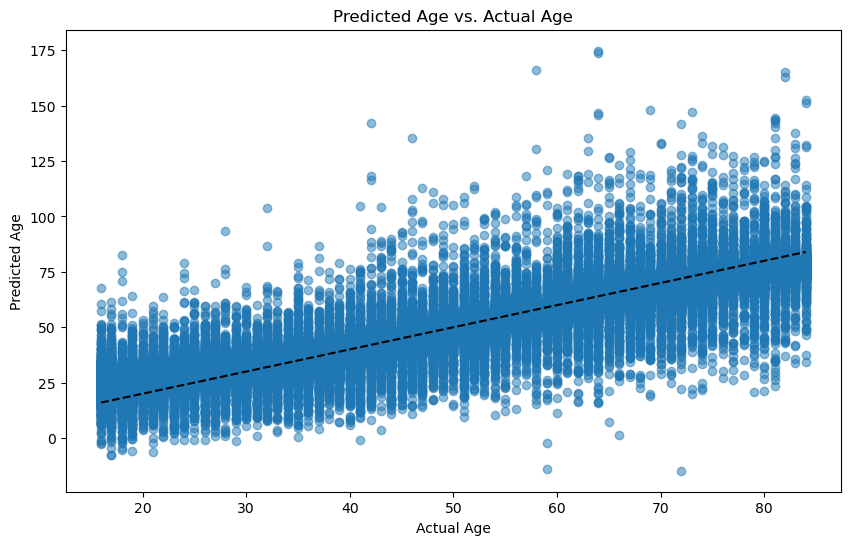

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from joblib import dump, load
import sys, os

def train_and_save_models(model, df, features, save_to='models/', n_splits=5):
    if not os.path.exists(save_to): os.mkdir(save_to)
    models_saved = []
    X = df[features]
    y = df["age"]

    kf = KFold(n_splits=n_splits)
    fold = 0
    for train_index, test_index in kf.split(X):
        fold += 1
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        df.loc[df.iloc[test_index].index, 'y_pred'] = y_pred.tolist()

        # Save the model for this fold
        model_filename = f'{save_to}/model_fold_{fold}.joblib'
        dump(model, model_filename)
        models_saved.append(model_filename)
        print(f'Model saved for fold {fold}: {model_filename}')

    return df, models_saved


train_df = df_filled.copy()

train_df['y_pred'] = None
train_df, models_saved = train_and_save_models(LinearRegression(), train_df, features, save_to='models/logreg/')
mae = mean_absolute_error(train_df['age'], train_df['y_pred'])
r2 = r2_score(train_df['age'], train_df['y_pred'])

print('MAE', mae, 'R2', r2)

# Plot y_pred against age
plt.figure(figsize=(10, 6))
plt.scatter(train_df['age'], train_df['y_pred'], alpha=0.5)
plt.title('Predicted Age vs. Actual Age')
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.plot([train_df['age'].min(), train_df['age'].max()], [train_df['age'].min(), train_df['age'].max()], 'k--') # Diagonal line
plt.show()

Model saved for fold 1: models/catboost/model_fold_1.joblib
Model saved for fold 2: models/catboost/model_fold_2.joblib
Model saved for fold 3: models/catboost/model_fold_3.joblib
Model saved for fold 4: models/catboost/model_fold_4.joblib
Model saved for fold 5: models/catboost/model_fold_5.joblib
MAE 8.275196213743769 R2 0.6584815104124071


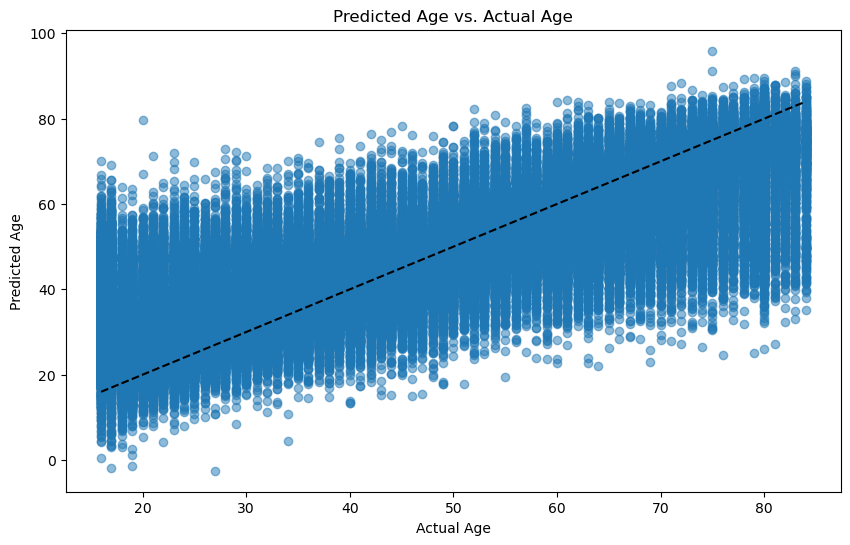

In [14]:
train_df = df_upscaled.copy()

train_df, models_saved = train_and_save_models(
    CatBoostRegressor(silent=True, random_state=42, max_depth=5), 
    train_df, features, save_to='models/catboost')
mae = mean_absolute_error(train_df['age'], train_df['y_pred'])
r2 = r2_score(train_df['age'], train_df['y_pred'])

print('MAE', mae, 'R2', r2)
# Plot y_pred against age
plt.figure(figsize=(10, 6))
plt.scatter(train_df['age'], train_df['y_pred'], alpha=0.5)
plt.title('Predicted Age vs. Actual Age')
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.plot([train_df['age'].min(), train_df['age'].max()], [train_df['age'].min(), train_df['age'].max()], 'k--') # Diagonal line
plt.show()

In [15]:
cb_model = load(models_saved[3])
cb_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,Estimated Glomerular Filtration Rate (mL/min/1...,37.274690
1,Waist to Height ratio,15.428224
2,Serum creatinine (mg/dL),14.515654
3,Serum blood urea nitrogen (mg/dL),7.465487
4,Serum ferritin (ng/mL),7.095173
5,Body Mass Index (kg/m**2),5.716171
6,alpha-tocopherol (µg/dL),3.906427
7,Serum albumin: SI (g/L),2.627706
8,Serum homocysteine: SI (umol/L),2.095987
9,Systolic blood pressure average,1.820607


In [ ]:
df['']

['Systolic blood pressure average',
 'Estimated Glomerular Filtration Rate (mL/min/1.73 m2)',
 'alpha-tocopherol (µg/dL)',
 'Serum homocysteine: SI (umol/L)',
 'Serum ferritin (ng/mL)',
 'Serum creatinine (mg/dL)',
 'Serum blood urea nitrogen (mg/dL)',
 'Serum HDL cholesterol (mg/dL)',
 'Serum albumin:  SI (g/L)',
 'Serum C-reactive protein (mg/dL)',
 'Body Mass Index (kg/m**2)',
 'Waist to Height ratio']

## get baseline scores

In [16]:
from sklearn.metrics import mean_absolute_error, r2_score

# Assuming y is already defined from the earlier steps

# Calculate the mean of the target variable
y_mean = df['age'].mean()

# Create an array of mean values that has the same shape as y for baseline prediction
y_pred_baseline = [y_mean] * len(df['age'])

# Calculate MAE and R^2 for the baseline
mae_baseline = mean_absolute_error(df['age'], y_pred_baseline)
r2_baseline = r2_score(df['age'], y_pred_baseline)

mae_baseline, r2_baseline


(17.2437881737384, 0.0)

# Inference

In [17]:
cb_model.feature_names_

['Systolic blood pressure average',
 'Estimated Glomerular Filtration Rate (mL/min/1.73 m2)',
 'alpha-tocopherol (µg/dL)',
 'Serum homocysteine: SI (umol/L)',
 'Serum ferritin (ng/mL)',
 'Serum creatinine (mg/dL)',
 'Serum blood urea nitrogen (mg/dL)',
 'Serum HDL cholesterol (mg/dL)',
 'Serum albumin:  SI (g/L)',
 'Serum C-reactive protein (mg/dL)',
 'Body Mass Index (kg/m**2)',
 'Waist to Height ratio']

In [18]:
models_paths = ['models/catboost/model_fold_1.joblib',
 'models/catboost/model_fold_2.joblib',
 'models/catboost/model_fold_3.joblib',
 'models/catboost/model_fold_4.joblib',
 'models/catboost/model_fold_5.joblib']
final_predictions = predict_and_average(test_df.iloc[0], models_saved)
final_predictions

23.447280395812776

# Проверяем точность на отложенной выборке

In [19]:
predictions = []

for i in tqdm(range(test_df.shape[0])):
    # Extract a single row as a DataFrame
    row = test_df.iloc[[i]]
    # Get the prediction for the current row
    final_pred = predict_and_average(row, models_saved)
    # Append the prediction to the list
    predictions.extend(final_pred)

# Add the predictions as a new column to the DataFrame
test_df['final_pred'] = predictions

mae_final_pred = mean_absolute_error(test_df['age'], test_df['final_pred'])
r2_final_pred = r2_score(test_df['age'], test_df['final_pred'])
mae_final_pred, r2_final_pred

  0%|          | 0/15611 [00:00<?, ?it/s]

(6.713979801338043, 0.7642829564018541)

/var/folders/gm/xnklr9cn25d9zttg6821cbrw0000gp/T/ipykernel_84664/2652563027.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_mae = test_df.groupby('Age Group').apply(lambda x: mean_absolute_error(x['age'], x['final_pred']))
/var/folders/gm/xnklr9cn25d9zttg6821cbrw0000gp/T/ipykernel_84664/2652563027.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  age_group_mae = test_df.groupby('Age Group').apply(lambda x: mean_absolute_error(x['age'], x['final_pred']))
/var/folders/gm/xnklr9cn25d9zttg6821cbr

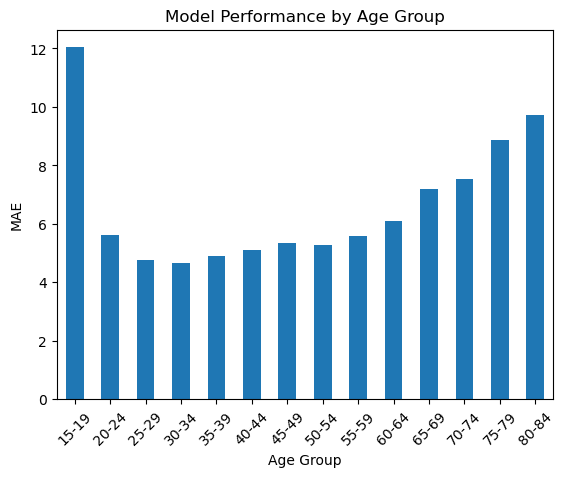

In [20]:
age_bins = np.arange(15, 90, 5)
age_labels = [f'{age_bins[i]}-{age_bins[i+1]-1}' for i in range(len(age_bins)-1)]

# Assuming the task is regression. For classification, you might use accuracy_score instead
age_group_mae = test_df.groupby('Age Group').apply(lambda x: mean_absolute_error(x['age'], x['final_pred']))
age_group_r2 = test_df.groupby('Age Group').apply(lambda x: r2_score(x['age'], x['final_pred']))

age_group_mae.plot(kind='bar')
plt.title('Model Performance by Age Group')
plt.xlabel('Age Group')
plt.ylabel('MAE')  # Or replace with 'Accuracy' or other relevant metrics
plt.xticks(rotation=45)
plt.show()


## Проверяем точность на отложенной выборке с заполненными пропусками средними значениями для возрастной группы


In [44]:
test_df_filled = fill_na_from_lookup(test_df, features, avgs_for_age_group)
test_df_filled

,Waist Circumference (cm),Standing Height (cm),Weight (kg),Systolic blood pressure average,Estimated Glomerular Filtration Rate (mL/min/1.73 m2),alpha-tocopherol (µg/dL),Serum homocysteine: SI (umol/L),Serum ferritin (ng/mL),Serum creatinine (mg/dL),Serum blood urea nitrogen (mg/dL),Serum HDL cholesterol (mg/dL),Serum albumin: SI (g/L),Serum C-reactive protein (mg/dL),Body Mass Index (kg/m**2),Waist to Height ratio,gender,age,SEQN,SEQN_new,Age Group
95356,109.3,170.70,103.60,112.495050,119.206718,955.642725,7.400403,66.741876,0.91,13.0,47.0,48.0,0.390157,35.55,0.640305,1,22,74169.0,C-74169,20-24
13293,113.8,160.10,92.60,113.861493,84.011053,1128.114758,7.900000,8.000000,0.90,13.0,37.0,38.0,0.400000,36.13,0.710806,2,33,42138.0,I-42138,30-34
50976,77.6,170.80,67.50,115.679474,92.869973,1535.000000,7.990000,78.000000,0.80,7.0,75.0,46.0,0.170000,23.14,0.454333,2,39,24204.0,C-24204,35-39
90700,90.7,161.50,63.10,144.091727,76.195561,1547.801201,11.828074,162.912085,0.76,8.0,78.0,47.0,0.567360,24.19,0.561610,2,76,67454.0,C-67454,75-79
121162,116.6,157.30,95.60,130.597720,94.272299,1330.000000,9.396372,120.000000,0.72,14.0,58.0,37.0,0.516858,38.64,0.741259,2,55,102309.0,C-102309,55-59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6471,79.0,175.00,70.55,113.861493,88.354872,1128.114758,7.486355,87.000000,1.10,16.0,51.0,42.0,0.210000,23.04,0.451429,1,32,16039.0,I-16039,30-34
87213,102.3,169.70,92.50,111.363748,108.714062,808.931160,7.136765,49.908892,0.64,6.0,62.0,39.0,0.247499,32.12,0.602829,2,16,63656.0,C-63656,15-19
119971,81.0,178.70,71.70,112.495050,101.908596,1140.000000,7.400403,102.000000,1.03,13.0,48.0,46.0,0.390157,22.45,0.453274,1,23,100985.0,C-100985,20-24
890,96.8,167.65,90.60,112.495050,92.044151,955.642725,7.400403,45.000000,0.90,10.0,38.0,41.0,0.210000,32.23,0.577393,2,20,2107.0,I-2107,20-24


In [45]:
predictions = []

for i in tqdm(range(test_df_filled.shape[0])):
    # Extract a single row as a DataFrame
    row = test_df_filled.iloc[[i]]
    # Get the prediction for the current row
    final_pred = predict_and_average(row, models_saved)
    # Append the prediction to the list
    predictions.extend(final_pred)

# Add the predictions as a new column to the DataFrame
test_df_filled['final_pred'] = predictions

mae_final_pred = mean_absolute_error(test_df_filled['age'], test_df_filled['final_pred'])
r2_final_pred = r2_score(test_df_filled['age'], test_df_filled['final_pred'])
mae_final_pred, r2_final_pred

  0%|          | 0/15611 [00:00<?, ?it/s]

ValueError: Length of values (31222) does not match length of index (15611)

/var/folders/gm/xnklr9cn25d9zttg6821cbrw0000gp/T/ipykernel_84664/2670566794.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_mae = test_df.groupby('Age Group').apply(lambda x: mean_absolute_error(x['age'], x['final_pred']))
/var/folders/gm/xnklr9cn25d9zttg6821cbrw0000gp/T/ipykernel_84664/2670566794.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  age_group_mae = test_df.groupby('Age Group').apply(lambda x: mean_absolute_error(x['age'], x['final_pred']))
/var/folders/gm/xnklr9cn25d9zttg6821cbr

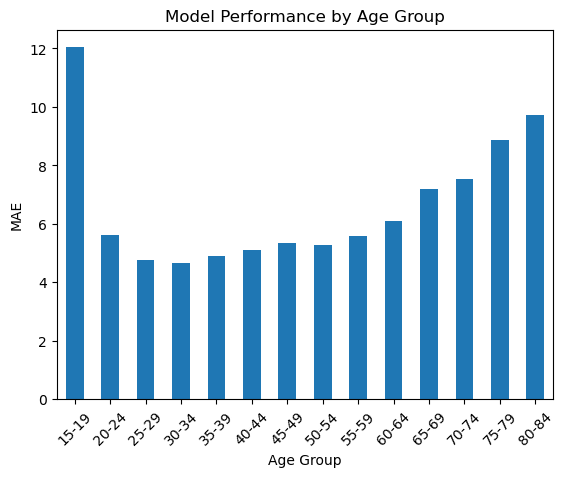

In [23]:
age_bins = np.arange(15, 90, 5)
age_labels = [f'{age_bins[i]}-{age_bins[i+1]-1}' for i in range(len(age_bins)-1)]

# Assuming the task is regression. For classification, you might use accuracy_score instead
age_group_mae = test_df.groupby('Age Group').apply(lambda x: mean_absolute_error(x['age'], x['final_pred']))
age_group_r2 = test_df.groupby('Age Group').apply(lambda x: r2_score(x['age'], x['final_pred']))

age_group_mae.plot(kind='bar')
plt.title('Model Performance by Age Group')
plt.xlabel('Age Group')
plt.ylabel('MAE')  # Or replace with 'Accuracy' or other relevant metrics
plt.xticks(rotation=45)
plt.show()

Точность с заполненными пропусками сильно выше чем если их не заполнять
* Проверили на отложенной выборки. Заполненные средние были взять из трейна, проверили на тесте

In [31]:
age_bins = np.arange(15, 90, 5)
age_labels = [f'{age_bins[i]}-{age_bins[i+1]-1}' for i in range(len(age_bins)-1)]
age_group = pd.cut([15], bins=age_bins, labels=age_labels, right=False)[0]
age_group


'15-19'

In [36]:
avgs_for_age_group = pd.read_csv('avgs_for_age_group.csv')
avgs_for_age_group

,Age Group,Systolic blood pressure average,Estimated Glomerular Filtration Rate (mL/min/1.73 m2),alpha-tocopherol (µg/dL),Serum homocysteine: SI (umol/L),Serum ferritin (ng/mL),Serum creatinine (mg/dL),Serum blood urea nitrogen (mg/dL),Serum HDL cholesterol (mg/dL),Serum albumin: SI (g/L),Serum C-reactive protein (mg/dL),Body Mass Index (kg/m**2),Waist to Height ratio
0,15-19,112.314975,102.974162,813.673358,7.057153,48.606190,0.814755,10.863530,51.083249,44.187218,0.256098,24.953700,0.501618
1,20-24,112.584821,110.876844,953.960897,7.444368,66.905666,0.856325,11.149702,52.061157,42.989710,0.390366,26.502920,0.530784
2,25-29,113.038855,106.462157,1091.054808,7.433134,83.662469,0.860469,11.430205,52.942553,42.647329,0.406392,27.502835,0.549562
3,30-34,113.742661,102.527722,1126.764388,7.405990,91.309555,0.861975,11.548718,51.656108,42.365454,0.437173,28.457388,0.565031
4,35-39,115.506599,97.945347,1168.355411,7.968919,104.241582,0.875635,11.981995,51.350539,42.449018,0.396973,28.904226,0.573036
5,40-44,120.223070,93.616479,1229.775282,8.365948,106.334720,0.890900,12.358655,51.146032,42.189936,0.416758,29.307041,0.583670
6,45-49,124.264171,90.990562,1297.543909,8.779729,123.806325,0.892437,12.679515,51.871848,42.078499,0.450600,29.439802,0.589781
7,50-54,126.075829,86.693294,1371.554680,9.405109,163.951370,0.906321,13.632387,52.809227,42.119558,0.462013,29.419433,0.597468
8,55-59,129.978441,82.226339,1439.090814,9.424954,174.857238,0.947325,14.203011,53.795772,41.893048,0.511389,29.476234,0.604913
9,60-64,134.949474,78.006829,1466.345462,9.870632,185.884286,0.971510,15.180112,52.740102,41.628636,0.568233,29.553518,0.612975


In [42]:
print('\n asd')


 asd
